# Imports

In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# file management imports
import os  ### only for count of images from dir, can be removed later

# image processing imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model imports for deep learning 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
import keras
from keras import optimizers
from keras.utils.np_utils import to_categorical 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


#for displaying images when predicting class
from PIL import Image 
#for rounding up fitting model for steps_per_epoch
import math


# Loading data

In [27]:
#loading train and test datasets from directory ../shapes
train_dir = 'shapes/train'
test_dir = 'shapes/valid'


#Spliting train and test sets by circle
train_dir_circle = train_dir+'/circle'
test_dir_circle = test_dir+'/circle'
#Spliting train and test sets by square
train_dir_square = train_dir+'/square'
test_dir_square = test_dir+'/square'
#Spliting train and test sets by triangle
train_dir_triangle = train_dir+'/triangle'
test_dir_triangle = test_dir+'/triangle'

# EDA

In [28]:
#checking the amount of images in each set
print('Total number of images in circle training set: ', len(os.listdir(train_dir_circle)))
print('Total number of images in circle test set:     ', len(os.listdir(test_dir_circle)))
print('Total number of images in square training set: ', len(os.listdir(train_dir_square)))
print('Total number of images in square test set:     ', len(os.listdir(test_dir_square)))
print('Total number of images in triangle training set:', len(os.listdir(train_dir_triangle)))
print('Total number of images in triangle test set:     ', len(os.listdir(test_dir_triangle)))

Total number of images in circle training set:  996
Total number of images in circle test set:      111
Total number of images in square training set:  1004
Total number of images in square test set:      111
Total number of images in triangle training set: 999
Total number of images in triangle test set:      111


In [29]:
#display image smaller (for checking manually)
def display_image(image_directory):
    im = image.load_img(image_directory)
    fig, ax = plt.subplots(figsize=(4,4))
    # displaying the image with figsize
    ax.imshow(im)

collage of sample images from circle folder


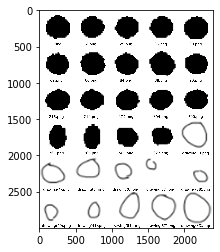

In [30]:
print('collage of sample images from circle folder')
display_image('collages/EDA_circles.jpg')

collage of sample images from square folder


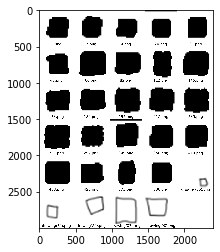

In [31]:
print('collage of sample images from square folder')
display_image('collages/EDA_squares.jpg')

collage of sample images from triangle folder


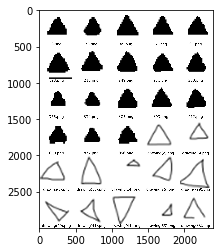

In [32]:
print('collage of sample images from triangle folder')
display_image('collages/EDA_triangles.jpg')

# Generator for image augmentation.

In [33]:
data_generator = ImageDataGenerator(        # Effects below randomly activates through each image per epoch                                    rescale = 1.0/255.0, 
                                    rescale = 1.0/255.0,
                                    zoom_range = 0.2,      # can randomly applies a zoom to the image (from 0 to 20%)
                                    rotation_range = 45,   # can randomly a rotation to the image (from 0 to 90 degrees)
                                    shear_range = 0.05,     # can randomly add skew to the image had to add to help with angling of the photos
                                    horizontal_flip=True,  # can randomly flips the image on the x-axis
                                    vertical_flip=True,    # can randomly flips the image on the y-axis
                                    )

# Fit generator to training and testing sets

In [34]:
classes= ['Circle','Square','Triangle']
batch_size = 32

#making tensorflow for training data
training_data = data_generator.flow_from_directory(directory= train_dir,
                                                   target_size = (64,64),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle=False)
#making tensorflow for testing data
testing_data = data_generator.flow_from_directory(directory= test_dir,
                                                   target_size = (64,64),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle=False)



Found 2996 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [35]:
# preparing model and layers in the Convolutional Deep Neural Network
num_classes = len(set(training_data.classes))
num_classes

3

# Building CNN model

In [45]:
model = Sequential()
#first convolutional layer
model.add(Conv2D(filters = 32,          # first layer should have the lowest filter size
                 kernel_size = (3, 3),  #kernel_size = (3, 3) b/c image size smaller then 128x128
                 activation = 'relu', 
                 input_shape = training_data.image_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.1))
#second convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
#third convolutional layer (last layer should have the highest filter size)
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))
# this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate = 0.5))

#output layer
model.add(Dense(units = num_classes, activation = 'softmax'))
#optimizer for compiler
Adam=keras.optimizers.Adam(lr=0.01)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy','mse'])

In [46]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)      

# Fit model to training and testing sets

In [47]:
total_training_size = len(os.listdir(train_dir_circle))+len(os.listdir(train_dir_square))+len(os.listdir(train_dir_triangle))
total_testing_size = len(os.listdir(test_dir_circle))+len(os.listdir(test_dir_square))+len(os.listdir(test_dir_triangle))

print(f"Total # of images in training set: {total_training_size}")
print(f"Total # of images in testing set: {total_testing_size}")

Total # of images in training set: 2999
Total # of images in testing set: 333


In [48]:
#Trains the model on the data batch-by-batch (bit-by-bit)
fitted_model = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil(total_training_size//batch_size), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 100,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/100
93/93 [==============================] - 62s 663ms/step - loss: 1.1137 - accuracy: 0.3789 - mse: 0.2223 - val_loss: 1.0067 - val_accuracy: 0.5467 - val_mse: 0.2026
Epoch 2/100
93/93 [==============================] - 57s 616ms/step - loss: 0.9617 - accuracy: 0.5175 - mse: 0.1931 - val_loss: 0.7611 - val_accuracy: 0.6140 - val_mse: 0.1532
Epoch 3/100
93/93 [==============================] - 56s 599ms/step - loss: 0.7649 - accuracy: 0.6339 - mse: 0.1544 - val_loss: 0.6922 - val_accuracy: 0.6612 - val_mse: 0.1356
Epoch 4/100
93/93 [==============================] - 44s 470ms/step - loss: 0.6739 - accuracy: 0.7075 - mse: 0.1340 - val_loss: 0.6491 - val_accuracy: 0.6626 - val_mse: 0.1330
Epoch 5/100
93/93 [==============================] - 36s 383ms/step - loss: 0.6467 - accuracy: 0.6933 - mse: 0.1282 - val_loss: 0.6026 - val_accuracy: 0.6937 - val_mse: 0.1241
Epoch 6/100
93/93 [==============================] - 36s 391ms/step - loss: 0.6150 - accuracy: 0.7223 - mse: 0.1212 - va

93/93 [==============================] - 46s 495ms/step - loss: 0.1404 - accuracy: 0.9519 - mse: 0.0232 - val_loss: 0.0603 - val_accuracy: 0.9823 - val_mse: 0.0091
Epoch 48/100
93/93 [==============================] - 45s 486ms/step - loss: 0.1134 - accuracy: 0.9627 - mse: 0.0194 - val_loss: 0.0711 - val_accuracy: 0.9829 - val_mse: 0.0089
Epoch 49/100
93/93 [==============================] - 45s 483ms/step - loss: 0.1097 - accuracy: 0.9651 - mse: 0.0183 - val_loss: 0.0613 - val_accuracy: 0.9821 - val_mse: 0.0086
Epoch 50/100
93/93 [==============================] - 43s 463ms/step - loss: 0.1356 - accuracy: 0.9518 - mse: 0.0230 - val_loss: 0.0476 - val_accuracy: 0.9859 - val_mse: 0.0063
Epoch 51/100
93/93 [==============================] - 41s 442ms/step - loss: 0.1206 - accuracy: 0.9632 - mse: 0.0187 - val_loss: 0.0544 - val_accuracy: 0.9831 - val_mse: 0.0082
Epoch 52/100
93/93 [==============================] - 42s 453ms/step - loss: 0.1256 - accuracy: 0.9578 - mse: 0.0210 - val_loss:

93/93 [==============================] - 37s 393ms/step - loss: 0.0900 - accuracy: 0.9744 - mse: 0.0136 - val_loss: 0.0355 - val_accuracy: 0.9919 - val_mse: 0.0042
Epoch 94/100
93/93 [==============================] - 37s 395ms/step - loss: 0.0941 - accuracy: 0.9723 - mse: 0.0147 - val_loss: 0.0272 - val_accuracy: 0.9938 - val_mse: 0.0034
Epoch 95/100
93/93 [==============================] - 37s 396ms/step - loss: 0.0903 - accuracy: 0.9727 - mse: 0.0137 - val_loss: 0.0287 - val_accuracy: 0.9938 - val_mse: 0.0033
Epoch 96/100
93/93 [==============================] - 37s 393ms/step - loss: 0.0784 - accuracy: 0.9777 - mse: 0.0122 - val_loss: 0.0324 - val_accuracy: 0.9937 - val_mse: 0.0034
Epoch 97/100
93/93 [==============================] - 39s 416ms/step - loss: 0.0744 - accuracy: 0.9774 - mse: 0.0123 - val_loss: 0.0335 - val_accuracy: 0.9913 - val_mse: 0.0042
Epoch 98/100
93/93 [==============================] - 38s 410ms/step - loss: 0.0644 - accuracy: 0.9760 - mse: 0.0111 - val_loss:

In [44]:
#Trains the model on the data batch-by-batch (bit-by-bit)
fitted_model = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil((total_training_size//batch_size)*3), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 33,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/33


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [49]:
model.save('model_with_rescaler_zoom-0.2_rotation-45_skew-0.05_flip-hori_verti-01.h5')  # save your weights and model after training

In [43]:
model= Sequential()
model_test=model.load_weights('model_with_zoom-0.2_rotation-45_skew-0.05_flip-hori_verti-01.h5')

ValueError: Weights for model sequential_7 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

# Plotting metrics from model

## Plot accuracy vs loss

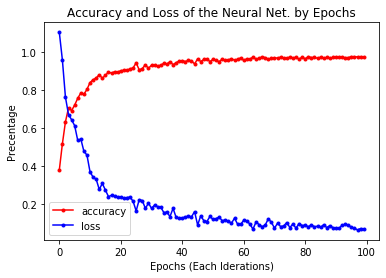

In [139]:
accuracy = fitted_model.history['accuracy']
loss = fitted_model.history['loss']
#plot accuracy for model
plt.plot(range(len(accuracy)), accuracy, 'r', marker= '.', label = 'accuracy')
#plot loss for model
plt.plot(range(len(loss)), loss, 'b', marker= '.', label = 'loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy and Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Cross Validation Accuracy and Cross validation accuracy

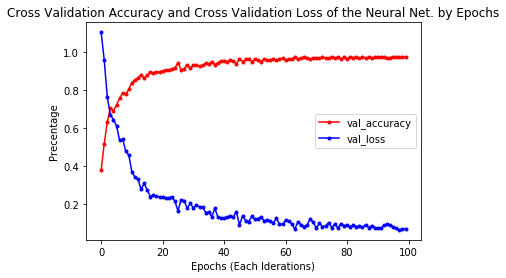

In [140]:
val_accuracy = fitted_model.history['val_accuracy'][:]
val_loss = fitted_model.history['val_loss'][:]
#plot cross validation accuracy for model
plt.plot(range(len(val_accuracy)), accuracy, 'r', marker= '.', label = 'val_accuracy')
#plot cross validation loss for model
plt.plot(range(len(val_loss)), loss, 'b', marker= '.', label = 'val_loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Cross Validation Accuracy and Cross Validation Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Accuracy vs Mean Squared Error

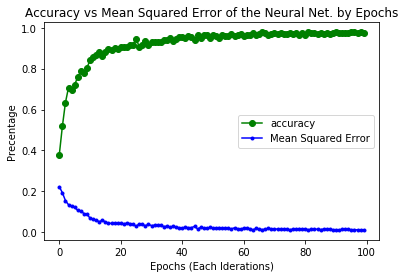

In [141]:
mse = fitted_model.history['mse'][:]

#plot accuracy for model
plt.plot(range(len(accuracy)), accuracy, 'g', marker= 'o', label = 'accuracy')
#plot mean squared error for model
plt.plot(range(len(mse)), mse, 'b', marker= '.', label = 'Mean Squared Error')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy vs Mean Squared Error of the Neural Net. by Epochs')
# plt.xticks(ticks=np.arange(2,25)
plt.legend()

# Confusion Matrix

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
# predicted_classes = np.argmax(predictions, axis=1)
true_classes = testing_data.classes
class_labels = list(testing_data.class_indices.keys()) 
print(class_labels)
print(true_classes)

['circle', 'square', 'triangle']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [55]:
predicted_classes = model.predict_classes(testing_data,verbose=0)
predicted_classes
for i in predicted_classes:
    print(i)

for i in predicted_classes:
    print(i)


ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x1a37188a20>, batch_size: 32

In [56]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

NameError: name 'predicted_classes' is not defined

# testing the model

In [57]:
#checking the labels for the classification 
train_labels = training_data.classes
train_labels = to_categorical(train_labels,num_classes)
# validation_labels = training_data.classes
# validation_labels = to_categorical(validation_labels,num_classes)
train_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [122]:
#function for predicting category of slected image
def testing_image(image_directory):

#     predicted_classes=
    
    # loading testing image with the target size for the image
    test_image = image.load_img(image_directory, target_size = (64,64))
    
    # converts image into an array
    test_image = image.img_to_array(test_image)
    # expands array (from converted image) with a new dimension(@ first position) for calculated category
    test_image = np.expand_dims(test_image, axis = 0)
    # making prediction based on test_image and labeling it results
    result = model.predict(x = test_image)
    # printing predictions
    print(result)
    
    #display image smaller (for checking manually)
    display_image(image_directory)

    # computing category weither a shape is a rectangle, square or triangle

#     if result[0][0] > result[0][1] and result[0][2]:
#         prediction = 'Circle'
#         print(f'The predicted shape in the image is {prediction}')
#     elif result[0][1] > result[0][0] and result[0][2]:
#         prediction = 'Square'
#         print(f'The predicted shape in the image is {prediction}')
#     elif result[0][2] > result[0][0] and result[0][1]:
#         prediction = 'Triangle'
#         print(f'The predicted shape in the image is {prediction}')
    

    if result[0][0] == 1:
        prediction = 'Circle'
        print(f'Predicted shape is {prediction}')
    elif result[0][1] == 1:
        prediction = 'Square'
        print(f'Predicted shape is {prediction}')
    elif result[0][2] == 1:
        prediction = 'Triangle'
        print(f'Predicted shape is {prediction}')
    

## Testing images grabbed online or drawn by hand

[[9.9999988e-01 7.3664680e-08 1.8231918e-17]]


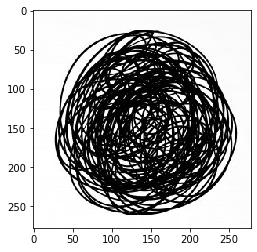

In [123]:
# print test image classified category
testing_image(test_dir + '/hand-drawn-circle-scribble.jpg')

[[1. 0. 0.]]
Predicted shape is Circle


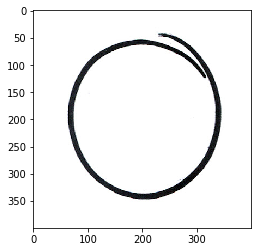

In [124]:
# print test image classified category
testing_image(test_dir + '/drawn_circle1.jpg')

[[0. 0. 1.]]
Predicted shape is Triangle


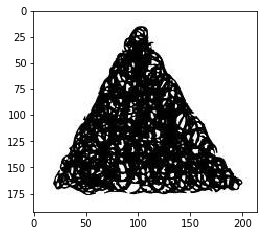

In [125]:
# print test image classified category
testing_image(test_dir + '/hand-drawn-pencil-scribble-triangles-01.jpg')

[[0. 0. 1.]]
Predicted shape is Triangle


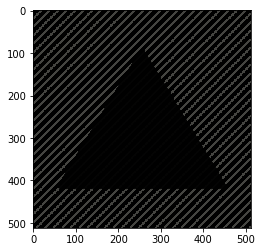

In [126]:
# print test image classified category
testing_image(test_dir + '/Triangle-3_-_Basic_UI_Glyph_Black-5-512.png')

[[0. 1. 0.]]
Predicted shape is Square


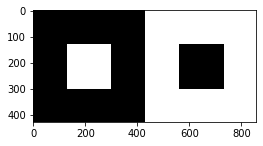

In [127]:
# print test image classified category
testing_image(test_dir+'/square-oq9l82oaujo11.jpg')

[[1. 0. 0.]]
Predicted shape is Circle


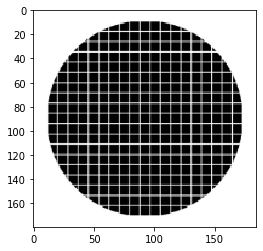

In [128]:
# print test image classified category
testing_image(test_dir + '/01_Circles_made_of_squares.png')


[[0. 1. 0.]]
Predicted shape is Square


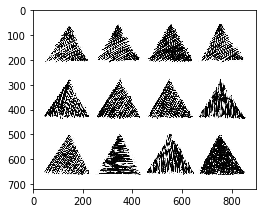

In [129]:
# print test image classified category
testing_image(test_dir + '/hand-drawn-pencil-scribble-triangles-andrii-shelenkov.jpg')


[[0. 0. 1.]]
Predicted shape is Triangle


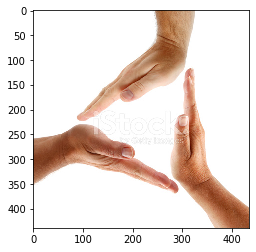

In [130]:
# print test image classified category
testing_image(test_dir + '/21063418-hands-in-triangle-shape.jpg')


[[0. 0. 1.]]
Predicted shape is Triangle


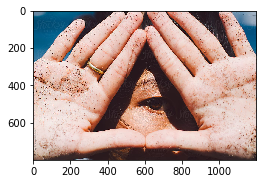

In [131]:
# print test image classified category
testing_image(test_dir + '/612310.jpg')


[[0. 1. 0.]]
Predicted shape is Square


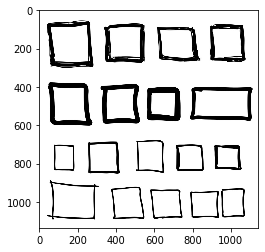

In [132]:
# print test image classified category
testing_image(test_dir + '/hand_drawn_squares.jpg')


[[0. 1. 0.]]
Predicted shape is Square


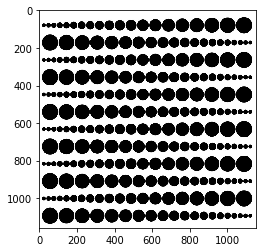

In [133]:
# print test image classified category
testing_image(test_dir + '/Screen Shot 2020-01-11 at 10.29.46 AM.png')


[[0. 0. 1.]]
Predicted shape is Triangle


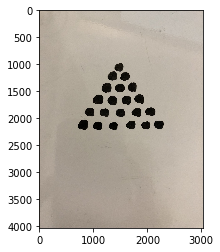

In [134]:
# print test image classified category
testing_image(test_dir + '/IMG_5265.jpg')


[[0. 0. 1.]]
Predicted shape is Triangle


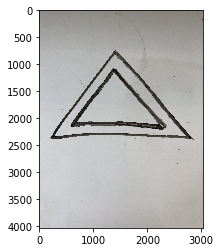

In [112]:
# print test image classified category
testing_image(test_dir + '/IMG_5254.jpg')


[[0. 0. 1.]]
Predicted shape is Triangle


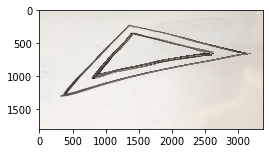

In [113]:
# print test image classified category
testing_image(test_dir + '/IMG_5255.jpg')


[[0. 0. 1.]]
Predicted shape is Triangle


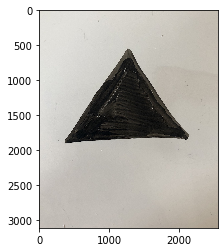

In [114]:
# print test image classified category
testing_image(test_dir + '/IMG_5258.jpg')


[[0. 1. 0.]]
Predicted shape is Square


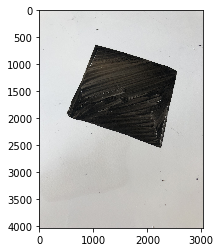

In [115]:
# print test image classified category
testing_image(test_dir + '/IMG_5259.jpg')


[[0. 1. 0.]]
Predicted shape is Square


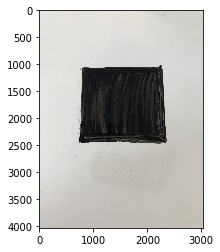

In [116]:
# print test image classified category
testing_image(test_dir + '/IMG_5260.jpg')


[[1. 0. 0.]]
Predicted shape is Circle


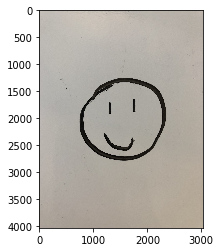

In [117]:
# print test image classified category
testing_image(test_dir + '/IMG_5261.jpg')


[[0. 1. 0.]]
Predicted shape is Square


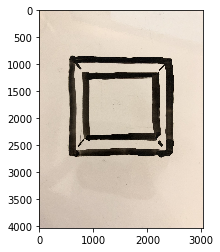

In [137]:
# print test image classified category
testing_image(test_dir + '/IMG_5264.jpg')
